In [8]:
import pandas as pd
import numpy as np
import os
import joblib
import time
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import parallel_backend

In [9]:
# load in the data 

promoters = pd.read_csv('Data/promoter.csv')
promoters.columns = ['Sequence']
non_promoters = pd.read_csv('Data/non_promoter.csv')
non_promoters.columns = ['Sequence']
label_vector = np.ones(promoters.shape[0]).tolist() + np.zeros(non_promoters.shape[0]).tolist()
combined_data = pd.concat([promoters, non_promoters], axis=0)

In [10]:
# train test validation split
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    combined_data, label_vector, test_size=0.2, stratify=label_vector, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, stratify=y_train_val, random_state=42
)  # 0.125 because 0.125 * 80% = 10%

# Check the sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 42000
Validation size: 6000
Test size: 12000


In [11]:
y_train = np.array(y_train)
print(X_train)
print(y_train)

                                                Sequence
8648   TGGCAAGGGGCCGTGGAGCCTGTAAGACTATCCCCCCAGCCACCCA...
27325  AATATGTAGGCAGTTTTCTTTGCTTTGACATGGAAGCAGTTTTAAC...
24871  TCCGCAGCTGGTGTCCTTCAACAAAAGTAATCACCTCTCTCCCCGG...
16509  TTCCCTGTTCTTCACAATCTGTGAGCACTGTAATGTTACACTTCAA...
12014  ACTAGGTCCTTCTTCCCCATGTTTTATACAGACGGACCAGAAGCCA...
...                                                  ...
17648  AATGAATATGTTGGAAATTATATGCAAATTGGCTTCCGTTGGTGTT...
28299  CACAGGCTTACAGGTACAGTCAGCGGACCCAGCCTGGGCTGGATCT...
14293  CCATCTCTGAGATATGTGGTCTTGACCTCCCAGCATGAAGTGTGCA...
27224  TCCGCTGAACTATTGCCCCCGACGGGCTTTGTTCGAAGACAATCAC...
14640  AGTGACATCGAGATGGGCTCTTTTCACCCCCCTCCCCCACTGCTCT...

[42000 rows x 1 columns]
[1. 0. 1. ... 0. 1. 0.]


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import numpy as np

class KmerVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to vectorize k-mers for different K values.
    """
    def __init__(self, K=3):
        self.K = K
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(self.K, self.K))
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        return self.vectorizer.transform(X)


def evaluate_model(best_model, X_test, y_test, model_name):
    """
    Evaluate a model on the reserved test set and generate metrics including ROC curves.

    Parameters:
    - best_model: The trained model to evaluate.
    - X_test: Test data (features).
    - y_test: Test labels.
    - model_name: Name of the model for saving results.

    Returns:
    - metrics: Dictionary of evaluation metrics.
    """
    print(f"Evaluating {model_name} on test data...")
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Compute metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
    }

    # Generate ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        metrics['roc_auc'] = roc_auc

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"ROC Curve for {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(f"{model_name}_roc_curve.png")
        plt.close()
        print(f"ROC curve saved as '{model_name}_roc_curve.png'")

    return metrics

def gridsearch_with_logging(X_train, y_train, model, param_grid, model_name, cv=5, scoring='accuracy', max_cpu_fraction=0.7):
    """
    Perform grid search with cross-validation, tracking progress and logging results, while limiting resource usage.

    Parameters:
    - X_train: Training data (features).
    - y_train: Training labels.
    - model: sklearn model.
    - param_grid: Parameter grid for grid search.
    - model_name: Name of the model for saving/loading files.
    - cv: Number of cross-validation folds.
    - scoring: Scoring metric.
    - max_cpu_fraction: Fraction of available CPU resources to use.

    Returns:
    - best_model: Trained pipeline with the best parameters.
    - best_params: Best parameter set.
    - best_score: Best cross-validation score.
    """
    # Check if the model is already trained
    model_file = f'best_{model_name}_model.pkl'
    log_file = f'{model_name}_gridsearch_log.csv'

    if os.path.exists(model_file):
        print(f"Model '{model_file}' already exists. Loading the model...")
        best_model = joblib.load(model_file)
        return best_model, None, None

    # Create pipeline
    pipeline = Pipeline([
        ('kmer', KmerVectorizer()),
        ('model', model)
    ])

    # Set up GridSearchCV
    total_combinations = np.prod([len(v) for v in param_grid.values()])
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,# Will be controlled by `parallel_backend`
        verbose= 4
    )

    # Custom callback for progress tracking
    current_combination = 0

    # Start grid search with resource constraints
    print(f"Starting grid search for {model_name} with up to {max_cpu_fraction * 100:.0f}% CPU usage...")

    with parallel_backend('loky', n_jobs=int(max_cpu_fraction * os.cpu_count())):
        grid_search.fit(X_train, y_train)

        # Save log
    results = pd.DataFrame(grid_search.cv_results_)
    results.to_csv(log_file, index=False)

    # Get the best model and save it
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_file)
    print(f"Best model saved as '{model_file}'")

    return best_model, grid_search.best_params_, grid_search.best_score_



0 0
1 0
2 0
0 1
1 1
2 1


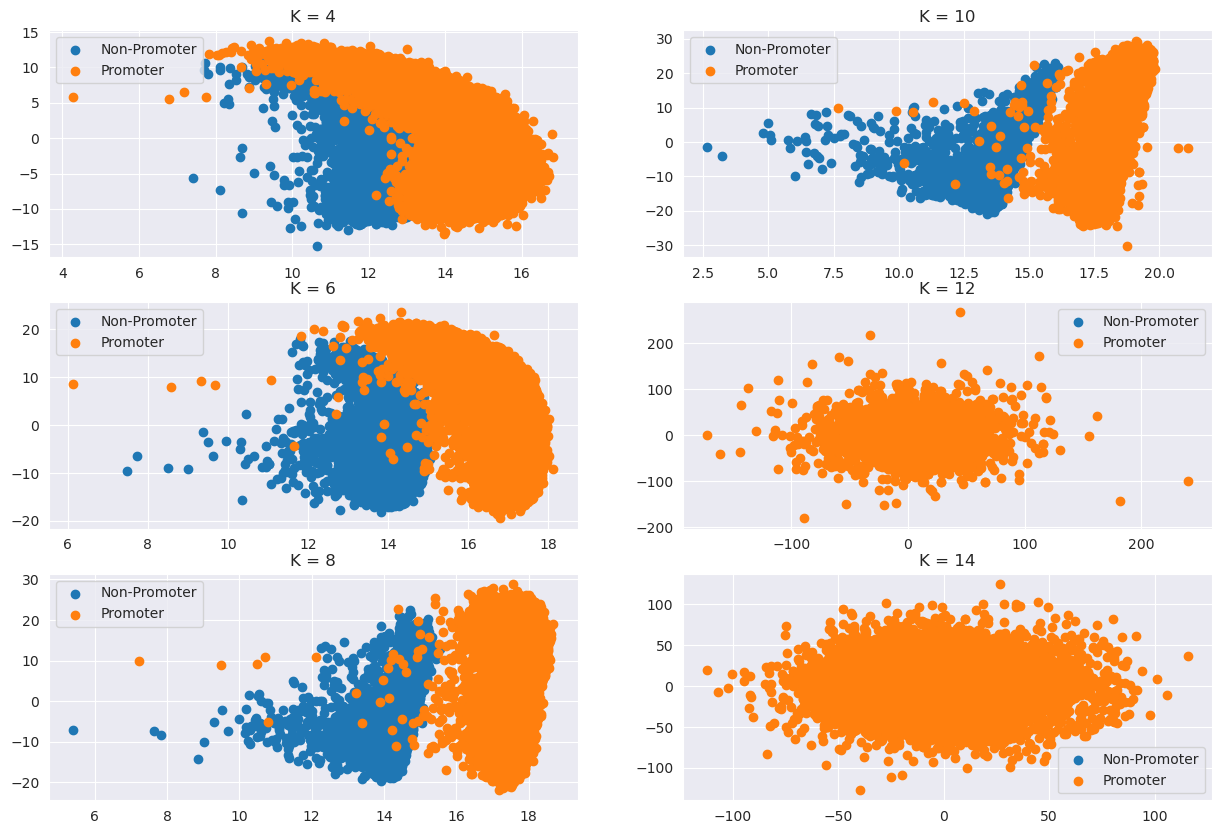

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
for i, K in enumerate([4, 6, 8, 10, 12, 14]):
    # Create pipeline
    pipeline = Pipeline([
        ('kmer', KmerVectorizer(K=K)),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', TruncatedSVD(n_components=2))
    ])

    # Fit and transform the data
    X_pca = pipeline.fit_transform(X_train['Sequence'].values)

    # Plot the data
    j = i // 3
    i = i % 3
    print(i, j)
    ax[i, j].scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], label='Non-Promoter')
    ax[i, j].scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], label='Promoter')
    ax[i, j].set_title(f"K = {K}")
    ax[i, j].legend()


In [14]:
# training Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
print(f"X_train shape: {len(X_train)}")
print(f"y_train shape: {len(y_train)}")
nb_model = MultinomialNB()
nb_param_grid = {
    'kmer__K': [4, 6, 8, 10],
    'model__alpha': [0.1, 0.5, 1.0],
}
best_nb_model, best_nb_params, best_nb_score = gridsearch_with_logging(
    X_train['Sequence'].values, y_train, nb_model, nb_param_grid, 'naive_bayes'
)
# displaying the best parameters and score
print("Best Parameters:", best_nb_params)


X_train shape: 42000
y_train shape: 42000
Model 'best_naive_bayes_model.pkl' already exists. Loading the model...
Best Parameters: None


/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline 

In [15]:
# evaluating the model
print(best_nb_params)
nb_metrics = evaluate_model(best_nb_model, X_test['Sequence'].values, y_test, 'naive_bayes')
print(nb_metrics)

None
Evaluating naive_bayes on test data...
ROC curve saved as 'naive_bayes_roc_curve.png'
{'accuracy': 0.83925, 'precision': 0.8749309265058022, 'recall': 0.7916666666666666, 'f1': 0.8312188292939015, 'roc_auc': 0.896454875}


In [16]:
# training Random Forest model
# Define the Random Forest model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'kmer__K': [4, 6, 8, 10,],  # Different k-mer sizes
    'model__n_estimators': [50, 100, 200],  # Number of trees
    'model__max_depth': [10, 20, 50, 100],  # Maximum depth of the trees
    'model__min_samples_split': [2],  # Minimum samples required to split an internal node
}

# Perform grid search with logging
best_rf_model, best_rf_params, best_rf_score = gridsearch_with_logging(
    X_train=X_train['Sequence'].values,
    y_train=y_train,
    model=model,
    param_grid=param_grid,
    model_name='random_forest',
    cv=5,
    scoring='accuracy'
)

Starting grid search for random_forest with up to 70% CPU usage...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 4/5] END kmer__K=6, model__max_depth=20, model__min_samples_split=2, model__n_estimators=50;, score=(train=0.916, test=0.867) total time=15.2min
[CV 2/5] END kmer__K=8, model__max_depth=100, model__min_samples_split=2, model__n_estimators=50;, score=(train=0.932, test=0.861) total time=19.5min
[CV 5/5] END kmer__K=6, model__max_depth=10, model__min_samples_split=2, model__n_estimators=200;, score=(train=0.843, test=0.830) total time= 8.9min
[CV 4/5] END kmer__K=8, model__max_depth=50, model__min_samples_split=2, model__n_estimators=100;, score=(train=0.885, test=0.837) total time=22.5min
[CV 5/5] END kmer__K=6, model__max_depth=20, model__min_samples_split=2, model__n_estimators=200;, score=(train=0.916, test=0.867) total time=40.0min
[CV 5/5] END kmer__K=4, model__max_depth=100, model__min_samples_split=2, model__n_estimators=100;, score=(train=1.000, te

/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best model saved as 'best_random_forest_model.pkl'


In [17]:
# Display the best parameters and score
print("Best Parameters:", best_rf_params)
rf_metrics = evaluate_model(best_rf_model, X_test['Sequence'].values, y_test, 'random_forest')
print(rf_metrics)

Best Parameters: {'kmer__K': 4, 'model__max_depth': 50, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Evaluating random_forest on test data...
ROC curve saved as 'random_forest_roc_curve.png'
{'accuracy': 0.90075, 'precision': 0.9372613202400436, 'recall': 0.859, 'f1': 0.8964257761544482, 'roc_auc': 0.9653667916666666}


In [ ]:
# training SVM model
from sklearn.svm import SVC
model = SVC(probability=True)
param_grid = {
    'kmer__K': [4, 6, 8, 10, ],
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'rbf', 'poly'],
}

best_svm_model, best_svm_params, best_svm_score = gridsearch_with_logging(
    X_train=X_train['Sequence'].values,
    y_train=y_train,
    model=model,
    param_grid=param_grid,
    model_name='svm',
    cv=5,
    scoring='accuracy'
)


Starting grid search for svm with up to 70% CPU usage...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
print("Best Parameters:", best_params)
svm_metrics = evaluate_model(best_svm_model, X_test['Sequence'].values, y_test, 'svm')
print(svm_metrics)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras